In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import joblib, pickle

In [2]:
# Load data

train = pd.read_csv("./data/train.csv")
train_extra = pd.read_csv("./data/training_extra.csv")
test = pd.read_csv("./data/test.csv")

# Concatenate train and train_extra datasets

train = pd.concat([train, train_extra], axis=0, ignore_index=True)

In [3]:
# Exploratory Data Analysis

print(train.info())
print(train.describe())
print(train.isnull().sum())
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB
None
                 id  Compartments  Weight Capacity (kg)         Price
count  3.994318e+06  3.994318e+06          3.992510e+06  3.994318e+06
mean   2.182137e+06  5.434740e+00          1.801042e+01  8.136217e+01
std    1.178058e+06  2.893043e+00          6.973969e+00  3.893868e+01
min    0.000000e+00  1.000000e+00          5.000000e+00  1.500000e+01
25%    1.1985

<ipython-input-4-9af3f3f97790>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train[col], ax=axes[idx], palette="Set2")
<ipython-input-4-9af3f3f97790>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train[col], ax=axes[idx], palette="Set2")
<ipython-input-4-9af3f3f97790>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train[col], ax=axes[idx], palette="Set2")
<ipython-input-4-9af3f3f97790>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to

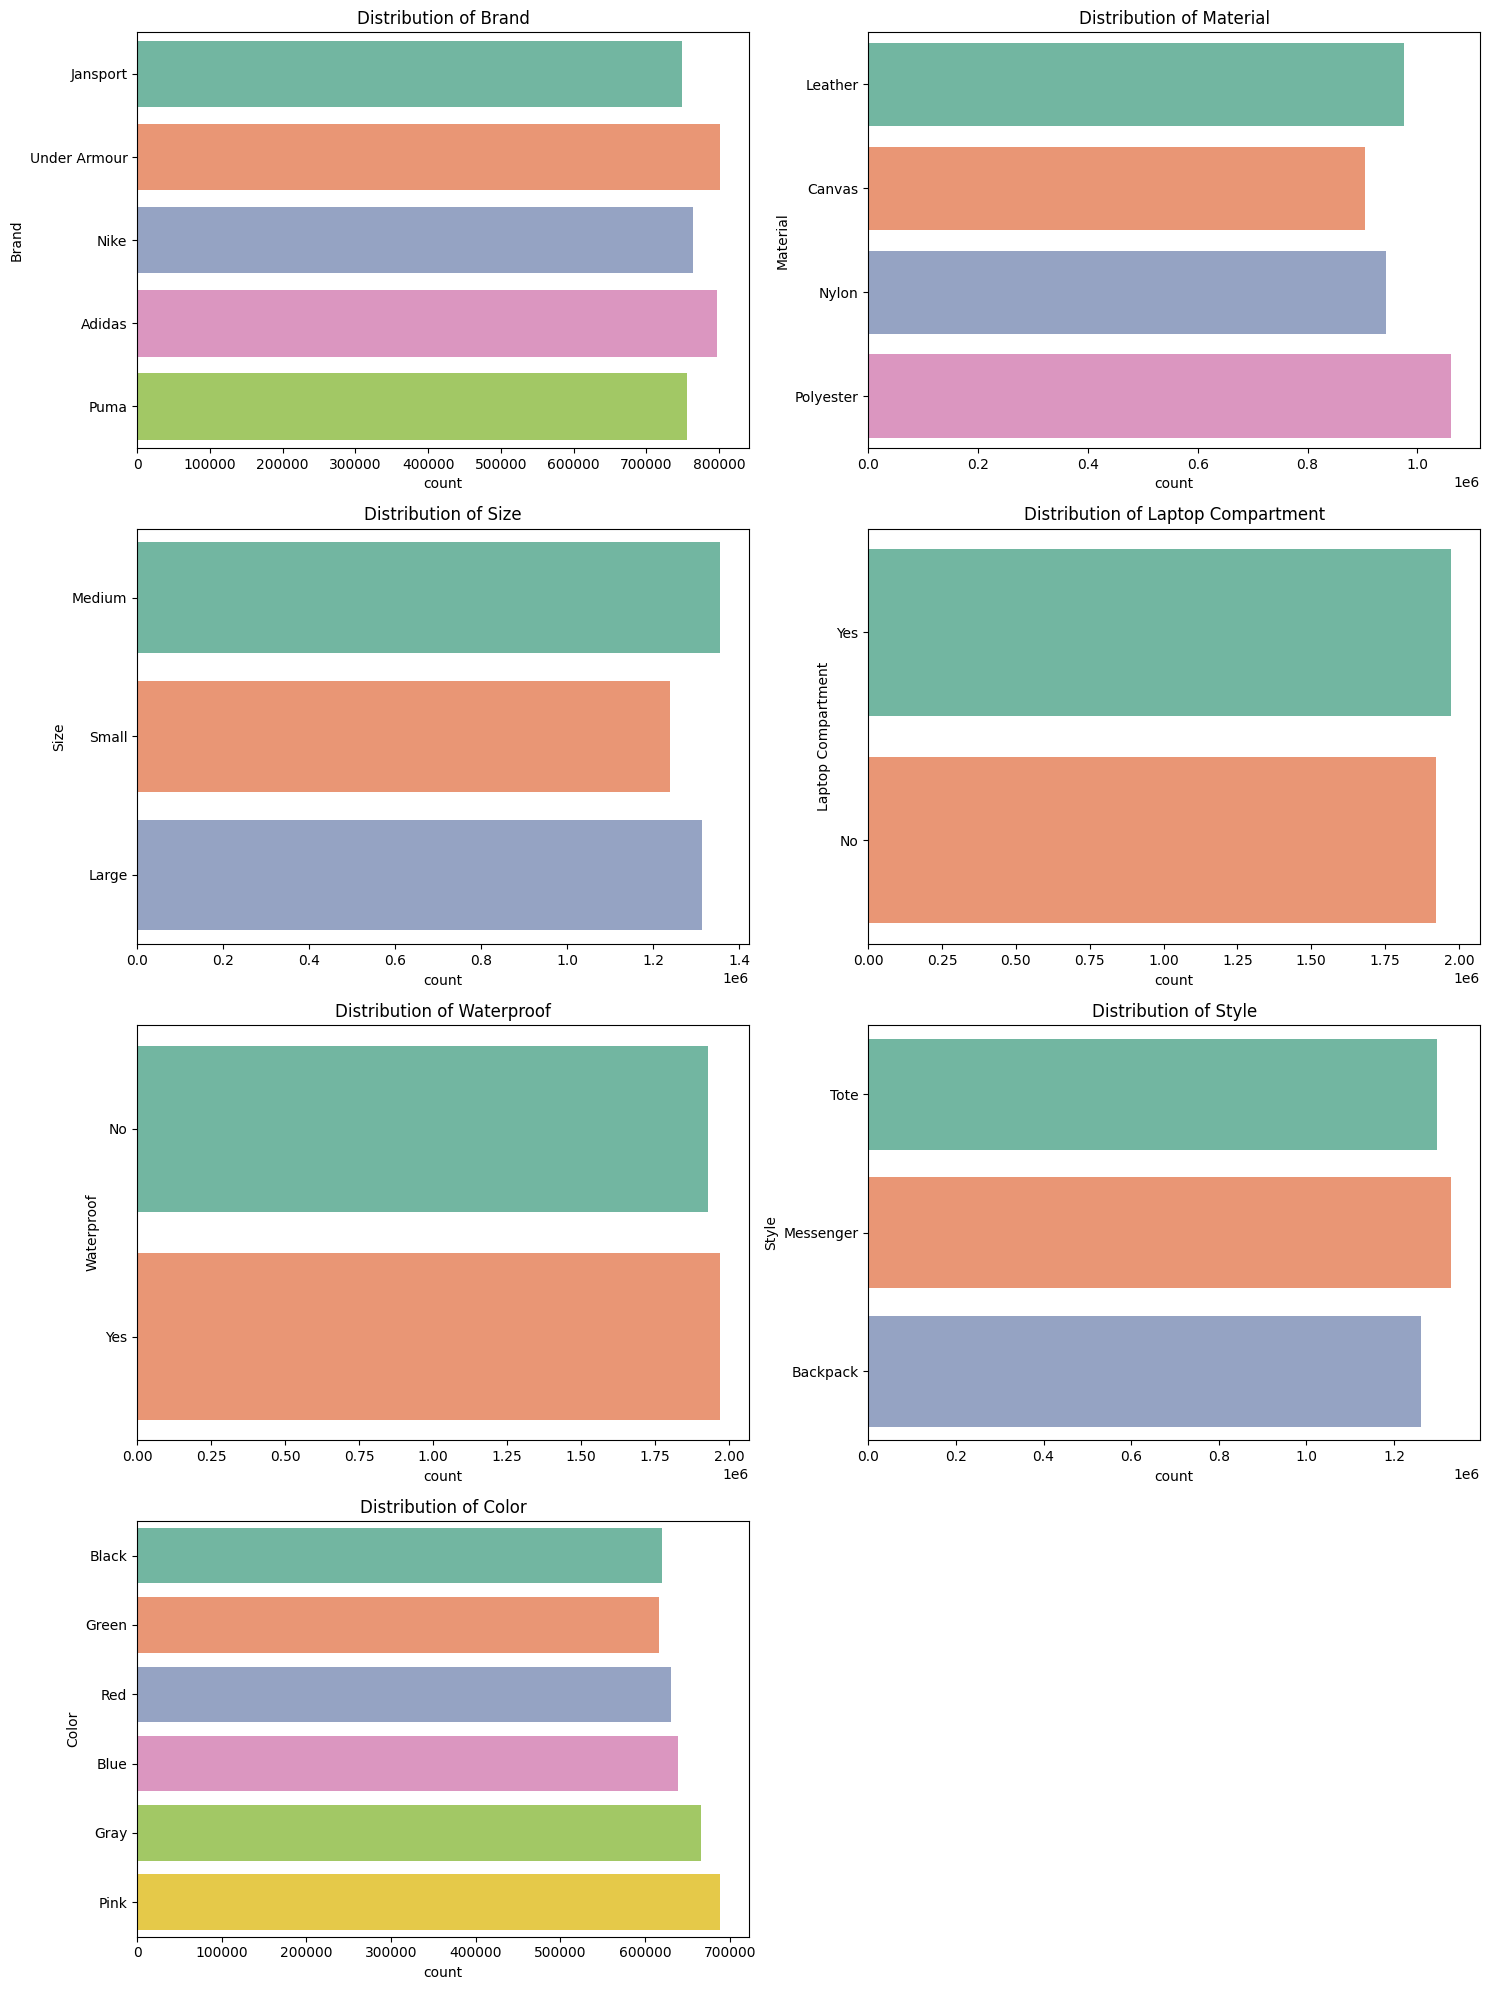

In [4]:
# Distribution of Categorical Features

categorical_cols = [col for col in train.columns if train[col].dtype == 'object']

n_cols = 2
n_rows = (len(categorical_cols) // n_cols) + (1 if len(categorical_cols) % n_cols != 0 else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    sns.countplot(y=train[col], ax=axes[idx], palette="Set2")
    axes[idx].set_title(f"Distribution of {col}")

for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [5]:
# Drop 'id' column

train.drop(columns=["id"], inplace=True)
test_ids = test["id"]
test.drop(columns=["id"], inplace=True)

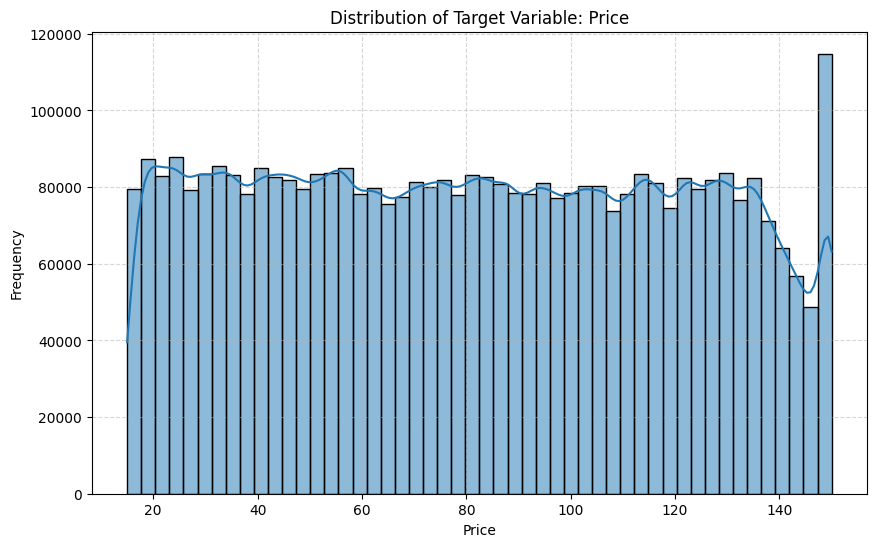

In [6]:
# Distribution of Target Variable: Price

plt.figure(figsize=(10,6))
sns.histplot(train["Price"], bins=50, kde=True)
plt.title("Distribution of Target Variable: Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

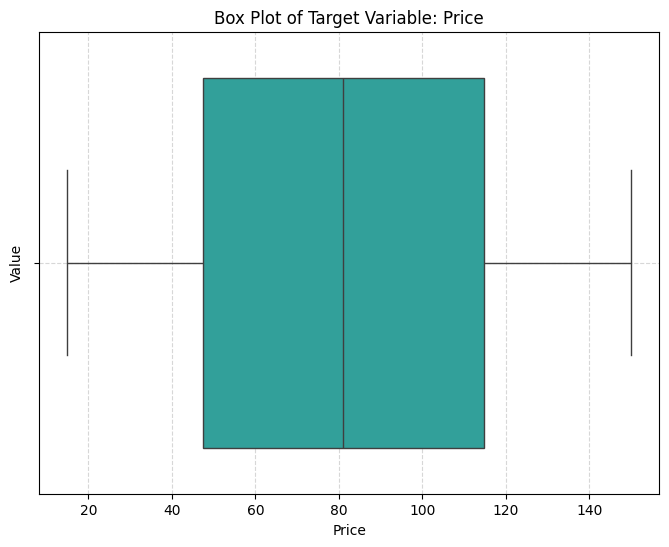

In [9]:
# Box Plot of Target Variable: Price

plt.figure(figsize=(8, 6))
sns.boxplot(x=train["Price"], color="lightseagreen")
plt.title("Box Plot of Target Variable: Price")
plt.xlabel("Price")
plt.ylabel("Value")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
# Identify categorical and numerical columns

categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
numerical_cols = [col for col in train.columns if train[col].dtype != 'object' and col != "Price"]

In [ ]:
# Handle missing values

imputer = ColumnTransformer([
    ('num_imputer', SimpleImputer(strategy='median'), numerical_cols),
    ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical_cols)
])

train[numerical_cols + categorical_cols] = imputer.fit_transform(train[numerical_cols + categorical_cols])
test[numerical_cols + categorical_cols] = imputer.transform(test[numerical_cols + categorical_cols])

In [ ]:
# Detect outliers using IQR method

Q1 = train['Price'].quantile(0.25)
Q3 = train['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['Price'] < lower_bound) | (train['Price'] > upper_bound)]
print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 0


In [ ]:
# Encode categorical features

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])

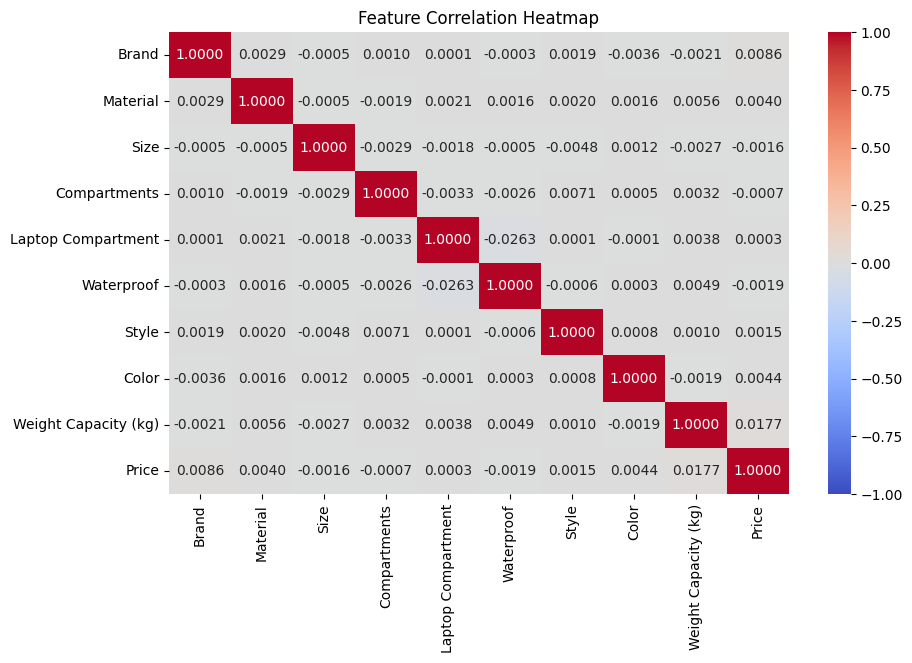

In [ ]:
# Feature Correlation Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm", fmt='.4f', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Standardize numerical features

scaler = StandardScaler()
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

In [ ]:
# Split data

X = train.drop(columns=["Price"])
y = train["Price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fix NaN issues in predictors

X_train = np.nan_to_num(X_train)
X_valid = np.nan_to_num(X_valid)
test = np.nan_to_num(test)

In [ ]:
# Train Random Forest model

rf = RandomForestRegressor(n_estimators=300, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=300, random_state=42)

In [ ]:
# Train XGBoost model

xgb = XGBRegressor(n_estimators=700, learning_rate=0.03, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x600 with 0 Axes>

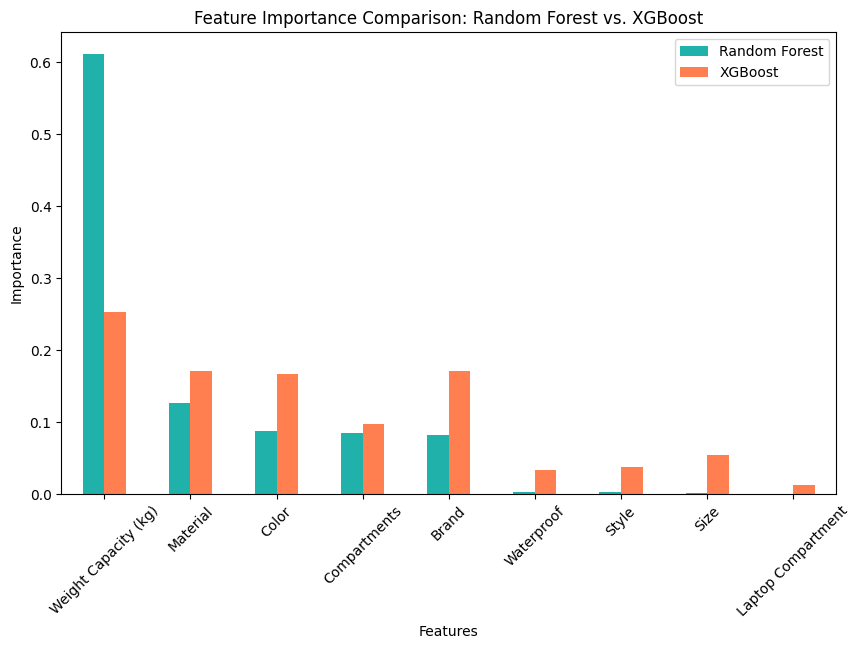

In [ ]:
# Feature Importance Analysis

plt.figure(figsize=(10,6))
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)

importance_df = pd.DataFrame({
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).sort_values(by="Random Forest", ascending=False)

importance_df.plot(kind="bar", figsize=(10,6), color=["lightseagreen", "coral"])
plt.title("Feature Importance Comparison: Random Forest vs. XGBoost")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Train Neural Network (ANN) model

ann = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(1)
])

ann.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
]

history = ann.fit(
    X_train, y_train,
    epochs=100, batch_size=64,
    validation_data=(X_valid, y_valid),
    verbose=1, callbacks=callbacks
)

Epoch 1/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 339s 7ms/step - loss: 1632.6052 - val_loss: 1516.3379 - learning_rate: 0.0010
Epoch 2/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 380s 7ms/step - loss: 1542.0189 - val_loss: 1516.7307 - learning_rate: 0.0010
Epoch 3/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 325s 6ms/step - loss: 1535.8939 - val_loss: 1514.3969 - learning_rate: 0.0010
Epoch 4/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 342s 7ms/step - loss: 1533.6514 - val_loss: 1514.4904 - learning_rate: 0.0010
Epoch 5/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 374s 7ms/step - loss: 1531.9358 - val_loss: 1514.0632 - learning_rate: 0.0010
Epoch 6/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 372s 6ms/step - loss: 1529.7466 - val_loss: 1514.2001 - learning_rate: 0.0010
Epoch 7/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 405s 7ms/step - loss: 1527.6589 - val_loss: 1513.8981 - learning_rate: 0.0010
Epoch 8/100
49929/49929 ━━━━━━━━━━━━━━━━━━━━ 356s 6ms/step - loss: 1527.2295 - val_loss: 1513.8105 - learning_rate: 0.0010
Epoch 9/100
4992

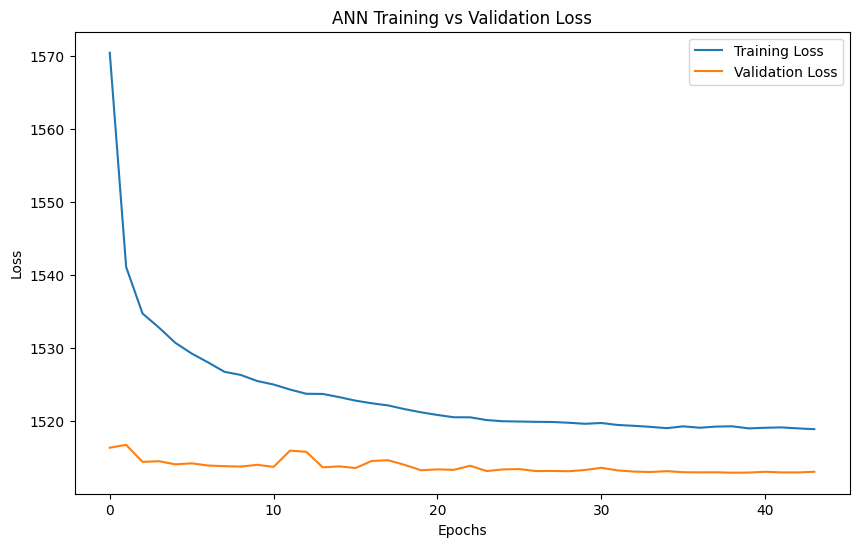

In [ ]:
# ANN Training vs Validation Loss Curve

plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training vs Validation Loss")
plt.legend()
plt.show()

24965/24965 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step


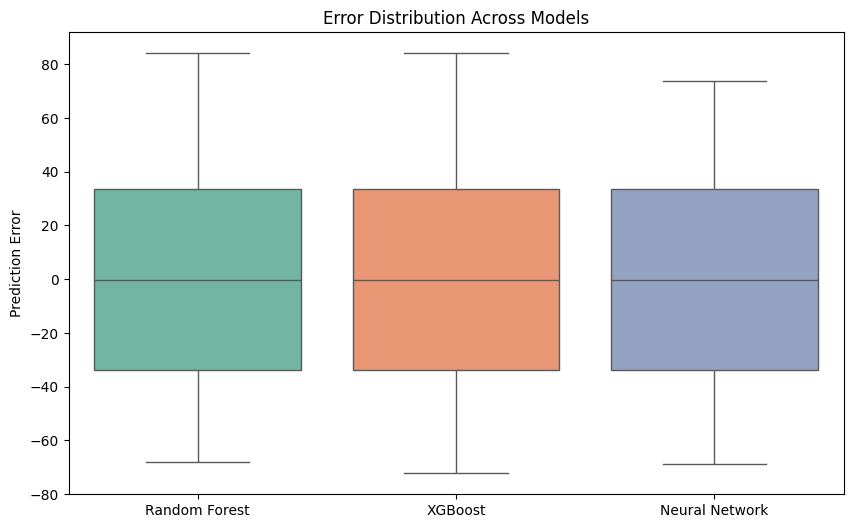

In [ ]:
# Calculate residuals (errors)

rf_errors = y_valid - rf.predict(X_valid)
xgb_errors = y_valid - xgb.predict(X_valid)
nn_errors = y_valid - ann.predict(X_valid).flatten()

# Create DataFrame for seaborn

errors_df = pd.DataFrame({
    "Random Forest": rf_errors,
    "XGBoost": xgb_errors,
    "Neural Network": nn_errors
})

plt.figure(figsize=(10,6))
sns.boxplot(data=errors_df, palette="Set2")

plt.title("Error Distribution Across Models")
plt.ylabel("Prediction Error")
plt.show()

In [ ]:
# Generate meta-features

train_preds = np.column_stack([
    rf.predict(X_valid),
    xgb.predict(X_valid),
    ann.predict(X_valid).flatten(),
    np.abs(rf.predict(X_valid) - xgb.predict(X_valid)),  # Difference between RF and XGB predictions
    (rf.predict(X_valid) + xgb.predict(X_valid) + ann.predict(X_valid).flatten()) / 3  # Average prediction
])

test_preds = np.column_stack([
    rf.predict(test),
    xgb.predict(test),
    ann.predict(test).flatten(),
    np.abs(rf.predict(test) - xgb.predict(test)),  # Difference between RF and XGB predictions
    (rf.predict(test) + xgb.predict(test) + ann.predict(test).flatten()) / 3  # Average prediction
])

24965/24965 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
24965/24965 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


In [ ]:
# Replace NaNs with column mean

train_preds = np.nan_to_num(train_preds, nan=np.nanmean(train_preds))
test_preds = np.nan_to_num(test_preds, nan=np.nanmean(test_preds))

In [ ]:
# Train meta-model

meta_model = LinearRegression()
meta_model.fit(train_preds, y_valid)
final_preds = meta_model.predict(test_preds)

24965/24965 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


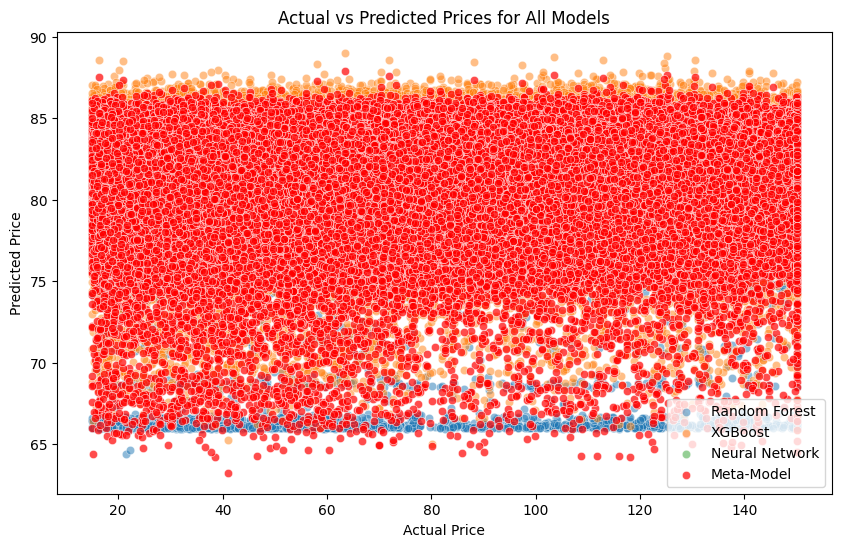

In [ ]:
# Actual vs Predicted Prices for All Models

plt.figure(figsize=(10,6))

sns.scatterplot(x=y_valid, y=rf.predict(X_valid), label="Random Forest", alpha=0.5)
sns.scatterplot(x=y_valid, y=xgb.predict(X_valid), label="XGBoost", alpha=0.5)
sns.scatterplot(x=y_valid, y=ann.predict(X_valid).flatten(), label="Neural Network", alpha=0.5)
sns.scatterplot(x=y_valid, y=meta_model.predict(train_preds), label="Meta-Model", alpha=0.7, color='red')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices for All Models")
plt.legend()
plt.show()

In [ ]:
# RMSE Evaluation

rf_rmse = np.sqrt(mean_squared_error(y_valid, rf.predict(X_valid)))
xgb_rmse = np.sqrt(mean_squared_error(y_valid, xgb.predict(X_valid)))
nn_rmse = np.sqrt(mean_squared_error(y_valid, ann.predict(X_valid).flatten()))
meta_rmse = np.sqrt(mean_squared_error(y_valid, meta_model.predict(train_preds)))

print(f"Random Forest RMSE: {rf_rmse}")
print(f"XGBoost RMSE: {xgb_rmse}")
print(f"Neural Network RMSE: {nn_rmse}")
print(f"Meta-Model RMSE: {meta_rmse}")

24965/24965 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
Random Forest RMSE: 38.891243588100146
XGBoost RMSE: 38.877478590294686
Neural Network RMSE: 38.89502980760267
Meta-Model RMSE: 38.87653261386354


<ipython-input-27-910a871895be>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=rmse_values, palette="Set2")


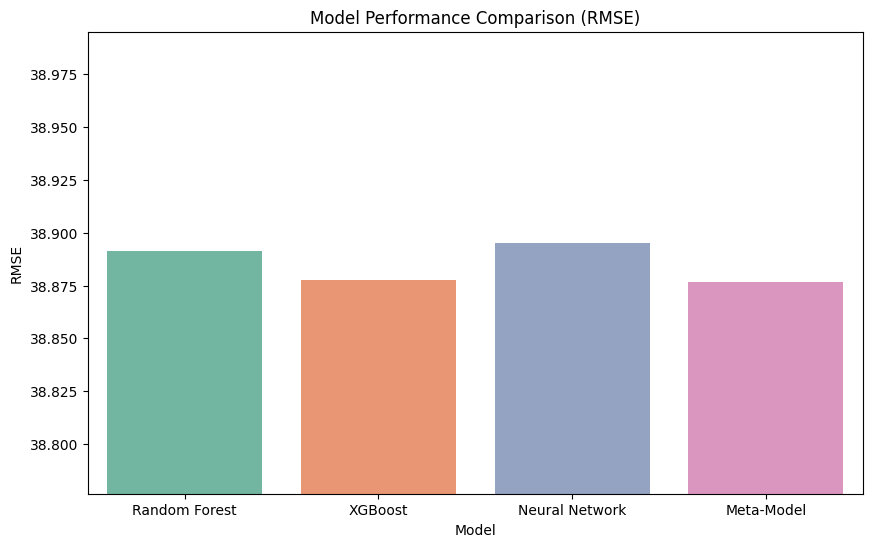

In [ ]:
# Model Performance Comparison (RMSE)

model_names = ["Random Forest", "XGBoost", "Neural Network", "Meta-Model"]
rmse_values = [rf_rmse, xgb_rmse, nn_rmse, meta_rmse]

plt.figure(figsize=(10,6))
sns.barplot(x=model_names, y=rmse_values, palette="Set2")

plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(min(rmse_values) - 0.1, max(rmse_values) + 0.1)
plt.show()

In [ ]:
# Prepare submission

submission = pd.DataFrame({"id": test_ids, "Price": final_preds})
submission.to_csv("submission_v2.csv", index=False)

In [ ]:
# Save models
with open("random_forest_v2.pkl", "wb") as rf_file:
    pickle.dump(rf, rf_file)

with open("xgboost_v2.pkl", "wb") as xgb_file:
    pickle.dump(xgb, xgb_file)

with open("meta_model_v2.pkl", "wb") as meta_file:
    pickle.dump(meta_model, meta_file)

ann.save("neural_network_v2.keras")

# Save encoders and scalers
encoder_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(train[col].astype(str))
    encoder_dict[col] = le

numerical_cols = ['Compartments', 'Weight Capacity (kg)']
scaler = StandardScaler()
scaler.fit(train[numerical_cols])

with open("encoder_v2.pkl", "wb") as enc_file:
    pickle.dump(encoder_dict, enc_file)

with open("scaler_v2.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)